# The Battle of the Neighborhoods - Week 2

## Download and Explore New York city geographical coordinates dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

Luckily, this dataset exists for free on the web. Link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

First, let's download all the dependencies that we will need.

In [249]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import folium # map rendering library
import csv # implements classes to read and write tabular data in CSV form
from bs4 import BeautifulSoup # package for parsing HTML and XML documents
from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print('Libraries imported.')

Libraries imported.


### Load and explore the data

In [119]:
geojson='E:/geojson.json'
with open(geojson) as json_data:
    newyork_data = json.load(json_data)

In [120]:
neighborhoods_data = newyork_data['features']

### Tranform the data into a pandas dataframe

In [121]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head(2)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939


In [122]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [123]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [124]:
map_NewYork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork)  
    
map_NewYork

## Web scrapping of Population and Demographics data of New York city from Wikipedia

#### A:Web scrapping of Population data from wikipedia page using BeautifulSoup.

In [125]:
website_url = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
#print(soup.prettify())

headers = [header.text for header in table.find_all('th')]

table_rows = table.find_all('tr')        
rows = []
for row in table_rows:
   td = row.find_all('td')
   row = [row.text for row in td]
   rows.append(row)

with open('BON2_POPULATION1.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerow(headers)
   writer.writerows(row for row in rows if row)

In [126]:
Pop_data=pd.read_csv('BON2_POPULATION1.csv')
Pop_data.drop(Pop_data.columns[[8,9,10,11,12,13,14]], axis=1,inplace=True)
Pop_data.columns = Pop_data.columns.str.replace(' ', '')
Pop_data.columns = Pop_data.columns.str.replace('\'','')
Pop_data.rename(columns={'Borough':'persons_sq_mi','County':'persons_sq_km'}, inplace=True)
Pop_data.rename(columns = {'NewYorkCitysfiveboroughsvte\r\n' : 'Borough',
                   'Jurisdiction\r\n':'County',
                   'Population\r\n':'Estimate_2017', 
                   'GrossDomesticProduct\r\n':'GDP',
                   'Landarea\r\n':'square_miles',
                    'Density\r\n':'square_km'},inplace=True)
Pop_data['Borough']=Pop_data['Borough'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['County']=Pop_data['County'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['GDP']=Pop_data['GDP'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['Estimate_2017']=Pop_data['Estimate_2017'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['square_miles']=Pop_data['square_miles'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['square_km']=Pop_data['square_km'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['persons_sq_mi']=Pop_data['persons_sq_mi'].replace(to_replace='\r\n', value='', regex=True)
Pop_data['persons_sq_km']=Pop_data['persons_sq_km'].replace(to_replace='\r\n', value='', regex=True)
Pop_data.loc[5:,['persons_sq_mi','persons_sq_km']] = Pop_data.loc[2:,['persons_sq_mi','persons_sq_km']].shift(1,axis=1)
Pop_data.loc[5:,['square_km','persons_sq_mi']] = Pop_data.loc[2:,['square_km','persons_sq_mi']].shift(1,axis=1)
Pop_data.loc[5:,['square_miles','square_km']] = Pop_data.loc[2:,['square_miles','square_km']].shift(1,axis=1)
Pop_data.loc[5:,['Estimate_2017','square_miles']] = Pop_data.loc[2:,['Estimate_2017','square_miles']].shift(1,axis=1)
Pop_data.loc[5:,['County','Estimate_2017']] = Pop_data.loc[2:,['County','Estimate_2017']].shift(1,axis=1)
Pop_data.loc[5:,['Borough','County']] = Pop_data.loc[2:,['Borough','County']].shift(1,axis=1)
Pop_data=Pop_data[['Borough','County','Estimate_2017','square_miles','square_km','persons_sq_mi','persons_sq_km']]
Pop_data = Pop_data.fillna('')
i = Pop_data[((Pop_data.County == 'Sources:[14] and see individual borough articles'))].index
Pop_data=Pop_data.drop(i)
Pop_data

,Borough,County,Estimate_2017,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,432,132","29,200",42.10,109.04,"34,653"
1,Brooklyn,Kings,"2,582,830","34,600",70.82,183.42,"37,137"
2,Manhattan,New York,"1,628,701","360,900",22.83,59.13,"72,033"
3,Queens,Queens,"2,278,906","39,600",108.53,281.09,"21,460"
4,Staten Island,Richmond,"476,179","30,300",58.37,151.18,"8,112"
5,,City of New York,"8,398,748",842.343,302.64,783.83,"28,188"
6,,State of New York,"19,745,289","1,701.399","47,214","122,284",416.4


In [127]:
Pop_data.to_csv('BON2_POPULATION.csv',index=False)

#### B:Demographic data.

In [128]:
Demo_data =pd.read_csv('E:/BON2_DEMOGRAPHICS.csv')
Demo_data.head()

,Racial composition,2010,1990,1970,1940
0,White,44.00%,52.30%,76.60%,93.60%
1,Non-Hispanic,33.30%,43.20%,62.90%,92.00%
2,Black or African American,25.50%,28.70%,21.10%,6.10%
3,Hispanic or Latino (of any race),28.60%,24.40%,16.20%,1.60%
4,Asian,12.70%,7.00%,1.20%,NaN


In [129]:
Demo_data.to_csv('BON2_DEMOGRAPHICS.csv',index=False)

## Exploring Newyork Cusine Data and finding most preferred cusine

This data is extracted from the wikipedia Page - https://en.wikipedia.org/wiki/Cuisine_of_New_York_City

In [206]:
NYC_CUISINE=pd.read_csv('E:/BON3_NYC_CUISINE.csv')
NYC_CUISINE.head()

,Borough,Neighborhood,Cuisine
0,The Bronx,Bedford Park,"Mexican, Puerto Rican, Dominican, Korean"
1,The Bronx,Belmont,"Italian, Albanian"
2,The Bronx,City Island,"Italian, Seafood"
3,The Bronx,Morris Park,"Italian, Albanian"
4,The Bronx,Norwood,Filipino


In [207]:
NYC_CUISINE['Borough'].value_counts().to_frame()

,Borough
Brooklyn,20
Queens,18
Manhattan,13
The Bronx,9
Staten Island,5


# NEW YORK CITY CUISINE - WORD CLOUD

In [211]:
CUISINE_WC = NYC_CUISINE[['Cuisine']]
CUISINE_WC.to_csv('CUISINE_WC.txt', sep=',', index=False)
CUISINE_WC1 = open('CUISINE_WC.txt', 'r').read()
stopwords = set(STOPWORDS)
# instantiate a word cloud object
NYC_CUISINE_WC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_WC.generate(CUISINE_WC1)

### Word Cloud Visualization

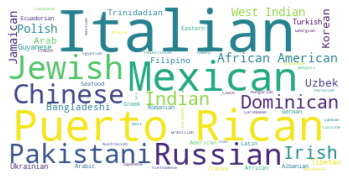

<Figure size 2160x3240 with 0 Axes>

In [214]:
plt.imshow(NYC_CUISINE_WC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

## From the above picture we can say the top 5 Preferred Foods in New York City are:

### 1. Italian

### 2. Purto Rican

### 3. Mexican

### 4. Jewish

### 5. Chinese

## Exploring the Farmers Market dataset

Data from website - https://data.cityofnewyork.us/dataset/DOHMH-Farmers-Markets-and-Food-Boxes/8vwk-6iz2

In [219]:
# Data from website - https://data.cityofnewyork.us/dataset/DOHMH-Farmers-Markets-and-Food-Boxes/8vwk-6iz2
FM_NYC = pd.read_csv("E:/DOHMH_Farmers_Markets.csv")
FM_NYC.head()

,Borough,Market Name,Street Address,Latitude,Longitude,Days of Operation,Hours of Operations,Season Dates,Accepts EBT,Open Year-Round,Stellar Cooking Demonstrations,Food Activities for Kids,Location Point
0,Brooklyn,Woodhull Hospital Youthmarket,Broadway & Flushing Ave,40.700726,-73.941932,Wednesday,9 a.m. - 2 p.m.,07/10/2019-11/27/2019,Yes,No,No,No,"(40.700726, -73.941932)"
1,Manhattan,Mount Sinai Hospital Greenmarket,E 99th St bet Madison & Park Aves,40.789169,-73.952743,Wednesday,8 a.m. - 5 p.m.,06/12/19-11/27/19,Yes,No,No,No,"(40.789169, -73.952743)"
2,Bronx,170 Farm Stand,E 170th St & Townsend Ave,40.839882,-73.916783,Wednesday,2:30 - 6:30 p.m.,07/10/2019-11/27/2019,Yes,No,No,Yes,"(40.839882, -73.916783)"
3,Manhattan,Greenmarket at Oculus Plaza,"Church & Fulton Sts, on Oculus Plaza",40.711535,-74.010464,Tuesday,7 a.m. - 7 p.m.,07/09/2019-11/30/19,Yes,Yes,No,No,"(40.711535, -74.010464)"
4,Queens,Ditmars Park Youthmarket,"Steinway St bet Ditmars Blvd & 23rd Ave, at Di...",40.772854,-73.906061,Saturday,8 a.m. - 3 p.m.,07/13/2019-11/23/2019,Yes,No,No,No,"(40.772854, -73.906061)"


#### Number of Markets available in each Borough :

In [222]:
print(FM_NYC.Borough.unique())
FM_NYC['Borough'].value_counts().to_frame()

['Brooklyn' 'Manhattan' 'Bronx' 'Queens' 'Staten Island']


,Borough
Brooklyn,44
Manhattan,41
Bronx,27
Queens,22
Staten Island,4


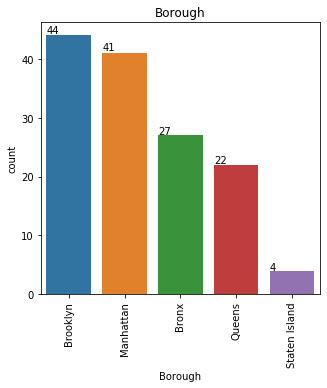

In [224]:
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
sns.countplot(x='Borough',data=FM_NYC)
ax.set_title("Borough")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate('', (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))
        ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.xticks(rotation=90) 
plt.show()

### Use geopy library to get the latitude and longitude values of New York City

In [225]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with Facility name and Borough of Farmers Market superimposed on top.

In [228]:
# create map of New York City using latitude and longitude values
map_markets = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, FacilityName, borough in zip(FM_NYC['Latitude'], FM_NYC['Longitude'], FM_NYC['Market Name'], FM_NYC['Borough']):
            label = '{}, {}'.format(FacilityName, borough)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
                parse_html = False).add_to(map_markets)  

map_markets

## Segmenting and Clustering Neighborhoods - Bronx and Queens

#### Explore the data:

In [229]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [230]:
neighborhoods['Borough'].value_counts().to_frame()

,Borough
Queens,81
Brooklyn,70
Staten Island,63
Bronx,52
Manhattan,40


### Segmenting and Clustering Neighborhoods - Bronx and Queens

In [232]:
BM_Geo = neighborhoods.loc[(neighborhoods['Borough'] == ' Bronx')|(neighborhoods['Borough'] == 'Queens')]
BM_Geo = BM_Geo.reset_index(drop=True)
BM_Geo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


#### Use geopy library to get the latitude and longitude values of New York City.

In [233]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of Bronx and Queens with neighborhoods superimposed on top.

In [235]:
# create map of Toronto using latitude and longitude values
map_BM = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(BM_Geo['Latitude'], BM_Geo['Longitude'], BM_Geo['Borough'], BM_Geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BM)  
    
map_BM

## Define Foursquare Credentials and Version

In [236]:
CLIENT_ID = 'OLN1BAQQBHO234LKFIU1ZNGV4Z3O3P1GS5KIMTNPJHLX1MKL' # your Foursquare ID
CLIENT_SECRET = 'VDM5CGGVSUOGKMY21ETO4J1UAJH5QJEALQCJAIWUF2DJXR2T' # your Foursquare Secret
VERSION = '20181218' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OLN1BAQQBHO234LKFIU1ZNGV4Z3O3P1GS5KIMTNPJHLX1MKL
CLIENT_SECRET:VDM5CGGVSUOGKMY21ETO4J1UAJH5QJEALQCJAIWUF2DJXR2T


### 2. Explore Neighborhoods in Bronx and Queens

#### Extract Venues data for each neighborhoods in Bronx

In [237]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=200, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called BM_venues.

In [238]:
BM_venues = getNearbyVenues(names=BM_Geo['Neighborhood'],
                                  latitudes=BM_Geo['Latitude'],
                                  longitudes=BM_Geo['Longitude'],
                                  LIMIT=200)

print('The "BM_venues" dataframe has {} venues and {} unique venue types.'.format(
      len(BM_venues['Venue Category']),
      len(BM_venues['Venue Category'].unique())))

BM_venues.to_csv('BM_venues.csv', sep=',', encoding='UTF8')
BM_venues.head()

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge
The "BM_venues" dataframe has 5299 venu

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
2,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
3,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts Dojo
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym


#### Download data from BM_venues.csv

In [239]:
colnames = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
BM_venues = pd.read_csv('BM_venues.csv', skiprows=1, names=colnames)
BM_venues.columns = BM_venues.columns.str.replace(' ', '')
BM_venues.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
2,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
3,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts Dojo
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym


In [240]:
BM_venues.groupby('VenueCategory')['Venue'].count().sort_values(ascending=False)

VenueCategory
Pizza Place                                 255
Chinese Restaurant                          159
Deli / Bodega                               147
Bakery                                      145
Donut Shop                                  144
Coffee Shop                                 121
Pharmacy                                    117
Bank                                        108
Bar                                         102
Italian Restaurant                          100
Sandwich Place                               97
Grocery Store                                92
Ice Cream Shop                               85
Korean Restaurant                            79
Park                                         77
Supermarket                                  75
Bus Station                                  74
Indian Restaurant                            73
Mexican Restaurant                           72
Fast Food Restaurant                         72
Diner                     

### Find out how many unique categories can be curated from all the returned venues

In [241]:
print('There are {} uniques categories.'.format(len(BM_venues['VenueCategory'].unique())))

There are 344 uniques categories.


# Filter restaurent Data

In [243]:
# one hot encoding
BM_onehot = pd.get_dummies(BM_venues[['VenueCategory']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(BM_onehot.columns)

# add neighborhood column back to dataframe
BM_onehot['Neighborhood'] = BM_venues['Neighborhood'] 

# move neighborhood column to the first column
BM_onehot = BM_onehot[column_names]

BM_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,Entertainment Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Rock Climbing Spot,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sauna / Steam Room,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping St

In [244]:
restaurant_List = []
search = 'Restaurant'
for i in BM_onehot.columns :
    if search in i:
        restaurant_List.append(i)

In [245]:
col_name = []
col_name = ['Neighborhood'] + restaurant_List
BM_restaurant = BM_onehot[col_name]
BM_restaurant = BM_restaurant.iloc[:,1::]

In [247]:
BM_restaurant_grouped = BM_restaurant.groupby('Neighborhood').sum().reset_index()
BM_restaurant_grouped['Total'] = BM_restaurant_grouped .sum(axis=1)

# Cluster Neighborhoods and Examine Clusters

In [250]:
BM_grouped_clustering = BM_restaurant_grouped.drop('Neighborhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(BM_grouped_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(BM_grouped_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.5297682913936954
For n_clusters=3, The Silhouette Coefficient is 0.4448485807695877
For n_clusters=4, The Silhouette Coefficient is 0.3422642214173685
For n_clusters=5, The Silhouette Coefficient is 0.374440067026552
For n_clusters=6, The Silhouette Coefficient is 0.28365721981146275
For n_clusters=7, The Silhouette Coefficient is 0.26782369721793287
For n_clusters=8, The Silhouette Coefficient is 0.2651743931862689
For n_clusters=9, The Silhouette Coefficient is 0.2775290625627594


#### As we can see, n_clusters=2 has highest Silhouette Coefficient. This means that 2 should be the optimal number of clusters.
#### For n_clusters=2, The Silhouette Coefficient is 0.529

### Run k-means to cluster the neighborhood into 2 clusters.

In [251]:
# set number of clusters
kclusters = 2

BM_grouped_clustering = BM_restaurant_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BM_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [252]:
BM_results = pd.DataFrame(kmeans.cluster_centers_)
BM_results.columns = BM_grouped_clustering.columns
BM_results.index = ['cluster0','cluster1']
BM_results['Total Sum'] = BM_results.sum(axis = 1)
BM_results

,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total,Total Sum
cluster0,0.035088,0.350877,0.052632,1.110223e-16,0.315789,-1.734723e-17,0.070175,4.857226e-17,0.052632,0.754386,1.666667,0.035088,-1.734723e-17,-6.938894e-17,-1.734723e-17,0.035088,0.035088,0.070175,-1.734723e-17,4.857226e-17,-1.734723e-17,0.894737,-1.387779e-16,0.035088,0.035088,0.017544,0.210526,0.052632,2.775558e-17,5.551115e-17,0.649123,2.775558e-17,0.982456,0.385965,0.157895,2.775558e-17,0.438596,0.017544,0.105263,0.315789,0.140351,-1.734723e-17,0.052632,-1.734723e-17,0.035088,-1.734723e-17,0.122807,-1.734723e-17,0.017544,-1.387779e-16,0.350877,0.017544,-3.469447e-17,0.192982,0.017544,0.035088,0.245614,0.122807,0.175439,2.775558e-17,0.315789,4.857226e-17,0.017544,0.017544,0.017544,0.210526,5.551115e-17,1.249001e-16,0.122807,0.052632,10.052632,20.105263
cluster1,0.041667,1.333333,0.291667,4.583333e-01,0.916667,4.166667e-02,0.208333,2.083333e-01,0.208333,0.375000,2.666667,0.125000,4.166667e-02,1.666667e-01,4.166667e-02,0.083333,0.416667,0.208333,4.166667e-02,2.083333e-01,4.166667e-02,0.875000,3.333333e-01,0.166667,0.041667,0.000000,1.208333,0.166667,1.250000e-01,2.500000e-01,1.500000,1.250000e-01,1.833333,1.125000,2.916667,1.250000e-01,1.375000,0.041667,0.416667,2.250000,0.500000,4.166667e-02,0.166667,4.166667e-02,0.000000,4.166667e-02,0.791667,4.166667e-02,0.000000,3.333333e-01,0.875000,0.000000,8.333333e-02,0.708333,0.041667,0.291667,0.958333,0.250000,0.250000,1.250000e-01,1.416667,2.083333e-01,0.083333,0.125000,0.000000,1.750000,2.500000e-01,3.750000e-01,0.375000,0.458333,33.583333,67.166667


### Clusters

In [254]:
BM_results_merged = pd.DataFrame(BM_restaurant_grouped['Neighborhood'])

BM_results_merged['Total'] = BM_restaurant_grouped['Total']
BM_results_merged = BM_results_merged.assign(Cluster_Labels = kmeans.labels_)
BM_merged = BM_Geo

BM_merged = BM_merged.join(BM_results_merged.set_index('Neighborhood'), on='Neighborhood')
BM_merged.head(10) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Queens,Astoria,40.768509,-73.915654,32,1
1,Queens,Woodside,40.746349,-73.901842,42,1
2,Queens,Jackson Heights,40.751981,-73.882821,54,1
3,Queens,Elmhurst,40.744049,-73.881656,60,1
4,Queens,Howard Beach,40.654225,-73.838138,19,0
5,Queens,Corona,40.742382,-73.856825,23,1
6,Queens,Forest Hills,40.725264,-73.844475,32,1
7,Queens,Kew Gardens,40.705179,-73.829819,10,0
8,Queens,Richmond Hill,40.697947,-73.831833,19,0
9,Queens,Flushing,40.764454,-73.831773,45,1


### Finally, let's visualize the resulting clusters

In [255]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BM_merged['Latitude'], BM_merged['Longitude'], BM_merged['Neighborhood'], BM_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1 : High Competition Markets

In [256]:
BM_merged[BM_merged['Cluster_Labels'] == 1].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Queens,Astoria,40.768509,-73.915654,32,1
1,Queens,Woodside,40.746349,-73.901842,42,1
2,Queens,Jackson Heights,40.751981,-73.882821,54,1
3,Queens,Elmhurst,40.744049,-73.881656,60,1
4,Queens,Corona,40.742382,-73.856825,23,1
5,Queens,Forest Hills,40.725264,-73.844475,32,1
6,Queens,Flushing,40.764454,-73.831773,45,1
7,Queens,Sunnyside,40.740176,-73.926916,30,1
8,Queens,Ridgewood,40.708323,-73.901435,29,1
9,Queens,Rego Park,40.728974,-73.857827,28,1


## Cluster 2 : Low Competition Markets

In [257]:
BM_merged[BM_merged['Cluster_Labels'] == 0].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude,Total,Cluster_Labels
0,Queens,Howard Beach,40.654225,-73.838138,19,0
1,Queens,Kew Gardens,40.705179,-73.829819,10,0
2,Queens,Richmond Hill,40.697947,-73.831833,19,0
3,Queens,Long Island City,40.750217,-73.939202,17,0
4,Queens,East Elmhurst,40.764073,-73.867041,11,0
5,Queens,Maspeth,40.725427,-73.896217,11,0
6,Queens,Glendale,40.702762,-73.870742,11,0
7,Queens,Woodhaven,40.689887,-73.858110,16,0
8,Queens,Ozone Park,40.680708,-73.843203,12,0
9,Queens,South Ozone Park,40.668550,-73.809865,9,0
